In [5]:
import json
import unicodedata
import re
from pathlib import Path
import xml.etree.ElementTree as ET
from matplotlib import colormaps
from matplotlib.colors import LogNorm

# === PATHS ===
POP_FILE = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network-1/AMP_population.json")
POLY_IN_FILE = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network/regions-based.poly.xml")
POLY_OUT_FILE = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network-1/AMP_heatmap.poly.xml")

# === NORMALIZATION FUNCTION ===

def normalize_commune_id(cid: str) -> str:
    """
    Normalize a commune identifier string by:
      - converting to lowercase,
      - replacing separators (_, -, ’, ', `) with spaces,
      - removing diacritical marks (accents),
      - collapsing multiple spaces into one,
      - stripping leading/trailing whitespace.
    """
    # lowercase and turn all separators into spaces
    plain = (
        cid.lower()
           .replace("_", " ")
           .replace("-", " ")
           .replace("’", " ")
           .replace("'", " ")
           .replace("`", " ")
           .strip()
    )
    # remove accents (e.g., é → e)
    no_accents = "".join(
        c for c in unicodedata.normalize("NFD", plain)
        if unicodedata.category(c) != "Mn"
    )
    # collapse any repeated whitespace into a single space
    return re.sub(r"\s+", " ", no_accents)

# === LOAD JSON AND NORMALIZE KEYS ===
with open(POP_FILE, "r", encoding="utf-8") as f:
    raw_data = json.load(f)

commune_pop = {
    normalize_commune_id(k): (v if isinstance(v, int) else v["population_total"])
    for k, v in raw_data.items()
}

# === COLOR SCALE ===
all_pops = list(commune_pop.values())
norm = LogNorm(vmin=max(1, min(all_pops)), vmax=max(all_pops))
cmap = colormaps["magma_r"]

def pop_to_color(pop):
    rgba = cmap(norm(pop))
    return f"{rgba[0]:.2f},{rgba[1]:.2f},{rgba[2]:.2f}"

# === PARSE POLYGON ===
tree = ET.parse(POLY_IN_FILE)
root = tree.getroot()

skipped = []
for poly in root.findall("poly"):
    raw_id = poly.attrib["id"].rsplit("_", 1)[0]
    commune_id = normalize_commune_id(raw_id)

    if commune_id not in commune_pop:
        skipped.append(commune_id)
        continue

    pop = max(commune_pop[commune_id], 1)
    poly.set("color", pop_to_color(pop))

# === SAVE FILE ===
tree.write(POLY_OUT_FILE, encoding="utf-8", xml_declaration=True)

# === REPORT ===
if skipped:
    print(f"⚠️ Skipped {len(skipped)} commune(s):", sorted(set(skipped)))
else:
    print("✅ All commune polygons matched with population data.")


✅ All commune polygons matched with population data.


In [ ]:
import json
import unicodedata
import re
from pathlib import Path
import xml.etree.ElementTree as ET
from matplotlib import colormaps
from matplotlib.colors import LogNorm

# === PATHS ===
POP_FILE      = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network-1/AMP_population.json")
POLY_IN_FILE  = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network/regions-based.poly.xml")
POLY_OUT_FILE = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network-1/AMP_heatmap.poly.xml")

# === NORMALIZATION FUNCTION ===
def normalize_commune_id(cid: str) -> str:
    plain = (
        cid.lower()
           .replace("_", " ")
           .replace("-", " ")
           .replace("’", " ")
           .replace("'", " ")
           .replace("`", " ")
           .strip()
    )
    no_accents = "".join(
        c for c in unicodedata.normalize("NFD", plain)
        if unicodedata.category(c) != "Mn"
    )
    return re.sub(r"\s+", " ", no_accents)

# === LOAD JSON AND NORMALIZE KEYS ===
with open(POP_FILE, "r", encoding="utf-8") as f:
    raw_data = json.load(f)

commune_pop = {
    normalize_commune_id(k): (v if isinstance(v, int) else v["population_total"])
    for k, v in raw_data.items()
}

# === COLOR SCALE ===
all_pops = list(commune_pop.values())
norm = LogNorm(vmin=max(1, min(all_pops)), vmax=max(all_pops))
cmap = colormaps["magma_r"]

def pop_to_color(pop):
    rgba = cmap(norm(pop))
    return f"{rgba[0]:.2f},{rgba[1]:.2f},{rgba[2]:.2f}"

# === PARSE POLYGON & ASSIGN COLOR + COLLECT THE DATA ===
tree = ET.parse(POLY_IN_FILE)
root = tree.getroot()

skipped = []
# region_communes: { region_type: [ (commune_id, pop), ... ] }
region_communes = {}

for poly in root.findall("poly"):
    raw_id     = poly.attrib["id"].rsplit("_", 1)[0]
    commune_id = normalize_commune_id(raw_id)
    region     = poly.attrib.get("type", "UNKNOWN")

    # nếu không có dân số, bỏ qua
    if commune_id not in commune_pop:
        skipped.append(commune_id)
        continue

    pop = max(commune_pop[commune_id], 1)
    # gán màu
    poly.set("color", pop_to_color(pop))

    # gom vào vùng
    region_communes.setdefault(region, []).append((commune_id, pop))

# === SAVE FILE ===
tree.write(POLY_OUT_FILE, encoding="utf-8", xml_declaration=True)

# === REPORT SKIPPED ===
if skipped:
    print(f"⚠️ Skipped {len(skipped)} commune(s):", sorted(set(skipped)))
else:
    print("✅ All commune polygons matched with population data.")

# === IN RA COMMUNE LỚN NHẤT / NHỎ NHẤT TỪNG VÙNG ===
print("\n=== Commune dân số LỚN NHẤT & NHỎ NHẤT theo vùng ===")
for region, lst in region_communes.items():
    # tìm min/max
    min_comm = min(lst, key=lambda x: x[1])
    max_comm = max(lst, key=lambda x: x[1])
    print(f"- Vùng '{region}':")
    print(f"    * Nhỏ nhất: {min_comm[0]} ({min_comm[1]} người)")
    print(f"    * Lớn nhất:  {max_comm[0]} ({max_comm[1]} người)")


✅ All commune polygons matched with population data.

=== Commune dân số LỚN NHẤT & NHỎ NHẤT theo vùng ===
- Vùng 'marseille':
    * Nhỏ nhất: plan de cuques (11396 người)
    * Lớn nhất:  marseille (873076 người)
- Vùng 'aix-en-provence':
    * Nhỏ nhất: saint antonin sur bayon (125 người)
    * Lớn nhất:  aix en provence (147478 người)
- Vùng 'est-etang-de-berre':
    * Nhỏ nhất: le rove (5194 người)
    * Lớn nhất:  vitrolles (35532 người)
- Vùng 'nord-ouest':
    * Nhỏ nhất: aurons (564 người)
    * Lớn nhất:  salon de provence (44731 người)
- Vùng 'ouest-etang-de-berre':
    * Nhỏ nhất: cornillon confoux (1571 người)
    * Lớn nhất:  martigues (48568 người)
- Vùng 'sud-est':
    * Nhỏ nhất: belcodene (1948 người)
    * Lớn nhất:  aubagne (47342 người)


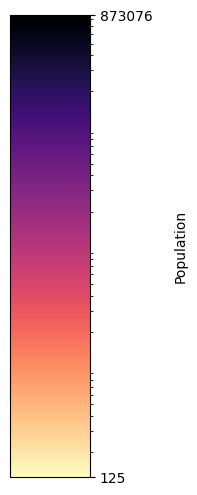

In [6]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LogNorm

# === ĐƯỜNG DẪN ĐẾN FILE POPULATION ===
POP_FILE = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network-1/AMP_population.json")

# === LOAD DỮ LIỆU VÀ TÍNH MIN/MAX ===
with POP_FILE.open("r", encoding="utf-8") as f:
    raw_data = json.load(f)

# Giải nén population_total nếu cần
all_pops = []
for v in raw_data.values():
    if isinstance(v, dict) and "population_total" in v:
        all_pops.append(v["population_total"])
    elif isinstance(v, int):
        all_pops.append(v)

vmin = max(1, min(all_pops))
vmax = max(all_pops)

# === CHUẨN BỊ COLORMAP ===
norm = LogNorm(vmin=vmin, vmax=vmax)
cmap = colormaps["magma_r"]  # inverted magma

# === VẼ THANH MÀU DỌC ===
fig, ax = plt.subplots(figsize=(2, 6))
fig.subplots_adjust(left=0.5)  # đẩy khoảng trống bên trái ra vừa đủ cho nhãn

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # cần cho matplotlib cũ

cb = plt.colorbar(
    sm,
    cax=ax,
    orientation='vertical',
    ticks=[vmin, vmax]
)
cb.set_ticklabels([str(vmin), str(vmax)])
cb.set_label('Population', rotation=90, labelpad=15)

# Lưu ra file nếu cần
fig.savefig("population_colorbar_vertical.png", dpi=300, bbox_inches="tight")
plt.show()

In [34]:
from lxml import etree
from pathlib import Path
import json
import re
import unicodedata

# ------------------------------------------------------------------------
# INPUT / OUTPUT
# ------------------------------------------------------------------------
TAZ_FILE           = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network/taz-new.xml")
NET_FILE           = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network/connected-network.net.xml")
MAPPING_FILE       = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/processed-data/AMP-mapping.json")
POP_FILE           = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network-1/AMP_population.json")
OUTPUT_TAZ_FILE    = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network/taz_weighted.xml")

# ------------------------------------------------------------------------
# HẰNG SỐ
# ------------------------------------------------------------------------
type_weights = {
    "highway.motorway":      0.5,
    "highway.motorway_link": 0.5,
    "highway.trunk":         0.6,
    "highway.trunk_link":    0.6,
    "highway.primary":       0.7,
    "highway.primary_link":  0.7,
    "highway.secondary":     0.8,
    "highway.secondary_link":0.8,
    "highway.tertiary":      1.0,
    "highway.tertiary_link": 1.0,
    "highway.residential":   1.1,
    "highway.living_street": 1.2,
    "highway.unclassified":  0.9,
    "default":               1.0,
}
POP_SCALE = 0.1    # 10% weight from population
EPSILON   = 1e-6   # minimal raw

# ------------------------------------------------------------------------
# helper: clamp + renormalize to per-zone sum=1, min weight EPSILON
# ------------------------------------------------------------------------
def renormalize(raw_list, min_w=EPSILON):
    raws = [r for _,r in raw_list]
    S = sum(raws) or 1.0
    norm = [r/S for r in raws]

    # clamp to min_w
    clamped = [w if w>=min_w else min_w for w in norm]
    # count and reserve for clamped
    N_clamped = sum(1 for w in clamped if w==min_w)
    reserve = N_clamped * min_w
    # sum of remaining
    sum_big = sum(w for w in clamped if w>min_w) or 1.0
    leftover = 1.0 - reserve

    final = []
    for w in clamped:
        if w==min_w:
            final.append(min_w)
        else:
            final.append(w/sum_big * leftover)
    return [(raw_list[i][0], final[i]) for i in range(len(final))]

# ------------------------------------------------------------------------
# load zone→communes mapping and population
# ------------------------------------------------------------------------
with open(MAPPING_FILE) as f:
    zone2communes = json.load(f)
with open(POP_FILE) as f:
    pop = json.load(f)

# compute total pop per zone, normalize [0,1]
zone_pop = {
    zn: sum(pop.get(c, 0) for c in (info.get("communes") or []))
    for zn, info in zone2communes.items()
}

max_pop = max(zone_pop.values()) or 1.0
zone_pop_norm = {zn: zone_pop[zn]/max_pop for zn in zone_pop}

# build id→normalized pop factor
id2pop = { info["id"]: zone_pop_norm.get(zn, 0.0)
           for zn, info in zone2communes.items() }

# ------------------------------------------------------------------------
# parse network: extract length & type per edge
# ------------------------------------------------------------------------
edge_length   = {}
edge_type_map = {}
tree_net = etree.parse(str(NET_FILE))
for edge in tree_net.findall(".//edge"):
    eid = edge.get("id")
    if eid.startswith(":"): 
        continue
    et = edge.get("type","default")
    edge_type_map[eid] = et
    length = max((float(l.get("length",0)) for l in edge.findall("lane")), default=0.0)
    edge_length[eid] = length

# ------------------------------------------------------------------------
# parse TAZ, compute & write weights
# ------------------------------------------------------------------------
tree_taz = etree.parse(str(TAZ_FILE))
root = tree_taz.getroot()

for taz in root.findall("taz"):
    zid = taz.get("id")                 # zone id
    pop_factor = id2pop.get(zid, 0.0)

    srcs = [s for s in taz.findall("tazSource") if not s.get("id","").startswith(":")]
    snks = [s for s in taz.findall("tazSink"  ) if not s.get("id","").startswith(":")]

    raw_src = []
    for s in srcs:
        eid = s.get("id")
        lw = edge_length.get(eid,0.0) * type_weights.get(edge_type_map.get(eid,"default"),1.0)
        raw = max(lw + POP_SCALE*pop_factor, EPSILON)
        raw_src.append((s, raw))

    raw_snk = []
    for s in snks:
        eid = s.get("id")
        lw = edge_length.get(eid,0.0) * type_weights.get(edge_type_map.get(eid,"default"),1.0)
        raw = max(lw + POP_SCALE*pop_factor, EPSILON)
        raw_snk.append((s, raw))

    # clamp & renormalize so sum==1 and each >= EPSILON
    src_norm = renormalize(raw_src, min_w=EPSILON)
    snk_norm = renormalize(raw_snk, min_w=EPSILON)

    for elem, w in src_norm:
        elem.set("weight", f"{w:.6f}")
    for elem, w in snk_norm:
        elem.set("weight", f"{w:.6f}")

# write out
tree_taz.write(str(OUTPUT_TAZ_FILE),
               encoding="utf-8",
               xml_declaration=True,
               pretty_print=True)

In [28]:
from lxml import etree
from pathlib import Path

OUTPUT_TAZ_FILE = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network/taz_weighted.xml")
tree_taz = etree.parse(str(OUTPUT_TAZ_FILE))
root_taz = tree_taz.getroot()

highest_weight_info = []

for taz in root_taz.findall("taz"):
    taz_id = taz.get("id")

    all_edges = taz.findall("tazSource") + taz.findall("tazSink")
    valid_edges = [
        (e.get("id"), float(e.get("weight", "0"))) for e in all_edges if not e.get("id", "").startswith(":")
    ]

    if not valid_edges:
        continue

    max_edge_id, max_weight = max(valid_edges, key=lambda x: x[1])
    highest_weight_info.append({
        "taz_id": taz_id,
        "edge_id": max_edge_id,
        "weight": round(max_weight, 6)
    })

import pandas as pd
df_max_weights = pd.DataFrame(highest_weight_info)
df_max_weights

,taz_id,edge_id,weight
0,2,645908665#0,0.002395
1,5,499717660,0.004110
2,3,33509275#0,0.002504
3,1,127010165,0.003022
4,6,635753772,0.004939
5,4,73519078#1,0.005591
6,99,242409214,0.002895


In [37]:
from lxml import etree
import sys

sys.path.append('/home/hoai-linh.dao/Works/EVCS/EV-Simulations/src') 
from config import PLOTNETDUMP_PY
TAZ_FILE    = "/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network/taz_weighted.xml"   # your TAZ file with weight attributes
OUT_EDGES   = "/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network/weights_for_draw.xml"        # what we will generate for plot_net_dump.py
INTERVAL_T  = "0.0"                # the timestamp label for this single interval
# ──────────────────────────────────────────────────────────────────────────

# 1) Load your weighted-TAZ file
tree = etree.parse(TAZ_FILE)
root = tree.getroot()

# 2) Create the <edgeData> root
edgeData = etree.Element("edgeData", id="TAZweights")

# 3) Create one <interval> and give it a timestamp
interval = etree.SubElement(edgeData, "interval", begin=INTERVAL_T)

# 4) For each TAZ, grab all the tazSource (and tazSink if you like)
for taz in root.findall("taz"):
    # sources
    for src in taz.findall("tazSource"):
        eid = src.get("id")
        w   = src.get("weight")
        if eid and w:
            etree.SubElement(interval, "edge", id=eid, weight=w)
    # sinks (uncomment if you also want to plot them)
    #for snk in taz.findall("tazSink"):
    #    eid = snk.get("id")
    #    w   = snk.get("weight")
    #    if eid and w:
    #        etree.SubElement(interval, "edge", id=eid, weight=w)

# 5) Write it out
out_tree = etree.ElementTree(edgeData)
out_tree.write(
    OUT_EDGES,
    pretty_print  = True,
    xml_declaration=True,
    encoding      ="UTF-8"
)

print(f"Wrote {OUT_EDGES} with {len(interval)} edges in interval={INTERVAL_T}")


Wrote /home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network/weights_for_draw.xml with 81242 edges in interval=0.0


In [40]:
import subprocess
cmd = [
    "python", PLOTNETDUMP_PY,
    "-n", NET_FILE,
    "-i", f"{OUT_EDGES},{OUT_EDGES}",
    "--measures", "weight,weight",
    "--min-width", "0.5",
    "--max-width", "3",
    "-s",       "12,8",        # 12 inches ngang, 8 inches dọc
    "--dpi",           "300",         # xuất 300 dpi
    "--color-bar-label", "TAZ weight",
    "-o", "taz_weights.png"
]

# ─────────────────────────────────────────────────────────────────────────────
# Run it
# ─────────────────────────────────────────────────────────────────────────────
subprocess.run(cmd, check=True)

Figure(1200x800)


CompletedProcess(args=['python', PosixPath('/home/hoai-linh.dao/Envs/sumo-env/lib/python3.10/site-packages/sumo/tools/visualization/plot_net_dump.py'), '-n', PosixPath('/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network/connected-network.net.xml'), '-i', '/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network/weights_for_draw.xml,/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/network/weights_for_draw.xml', '--measures', 'weight,weight', '--min-width', '0.5', '--max-width', '3', '-s', '12,8', '--dpi', '300', '--color-bar-label', 'TAZ weight', '-o', 'taz_weights.png'], returncode=0)

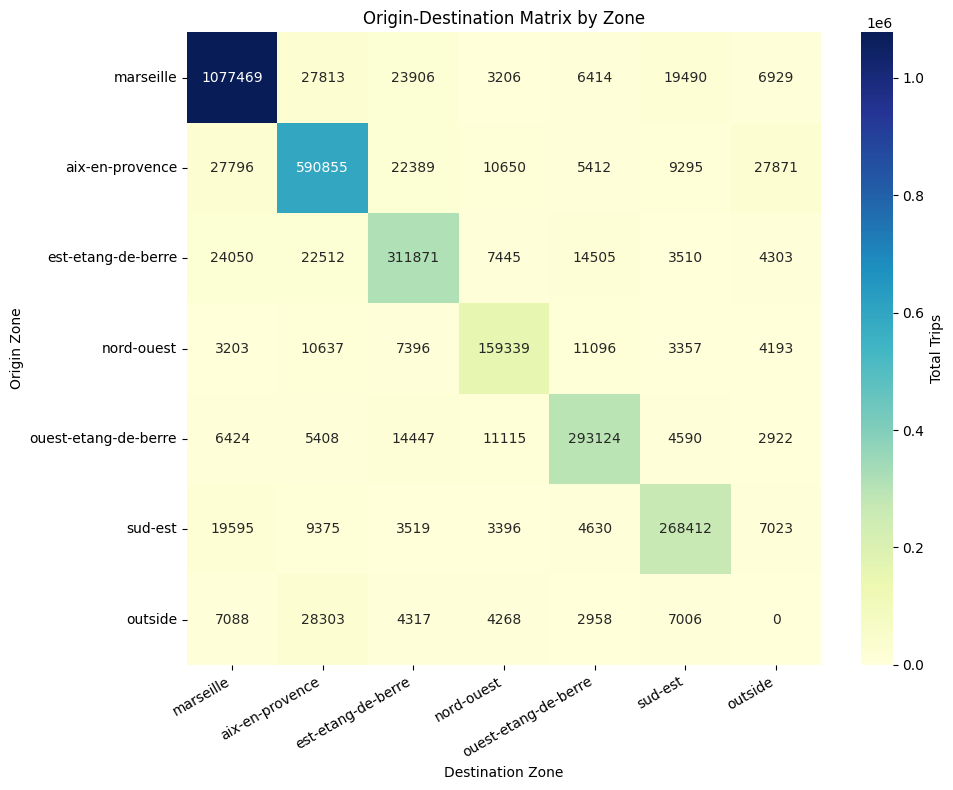

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define TAZ name mapping in desired order
ordered_taz = [
    'marseille',
    'aix-en-provence',
    'est-etang-de-berre',
    'nord-ouest',
    'ouest-etang-de-berre',
    'sud-est',
    'outside'
]

# Load the CSV file
csv_path = "/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/processed-data/total_scenario/statistics/directed_region_totals.csv"
df = pd.read_csv(csv_path)

# Map the IDs to names
TAZ_IDS = {
    '1': 'marseille',
    '2': 'aix-en-provence',
    '3': 'est-etang-de-berre',
    '4': 'nord-ouest',
    '5': 'ouest-etang-de-berre',
    '6': 'sud-est',
    '99': 'outside'
}
df['origin'] = df['origin'].astype(str).map(TAZ_IDS)
df['destination'] = df['destination'].astype(str).map(TAZ_IDS)

# Pivot to create OD matrix and reorder axes
od_matrix = df.pivot(index='origin', columns='destination', values='total_trips').fillna(0)
od_matrix = od_matrix.reindex(index=ordered_taz, columns=ordered_taz)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(od_matrix, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Total Trips'})
plt.title("Origin-Destination Matrix by Zone")
plt.xlabel("Destination Zone")
plt.ylabel("Origin Zone")
plt.xticks(rotation=30, ha='right')  # Tilt x-axis labels
plt.tight_layout()


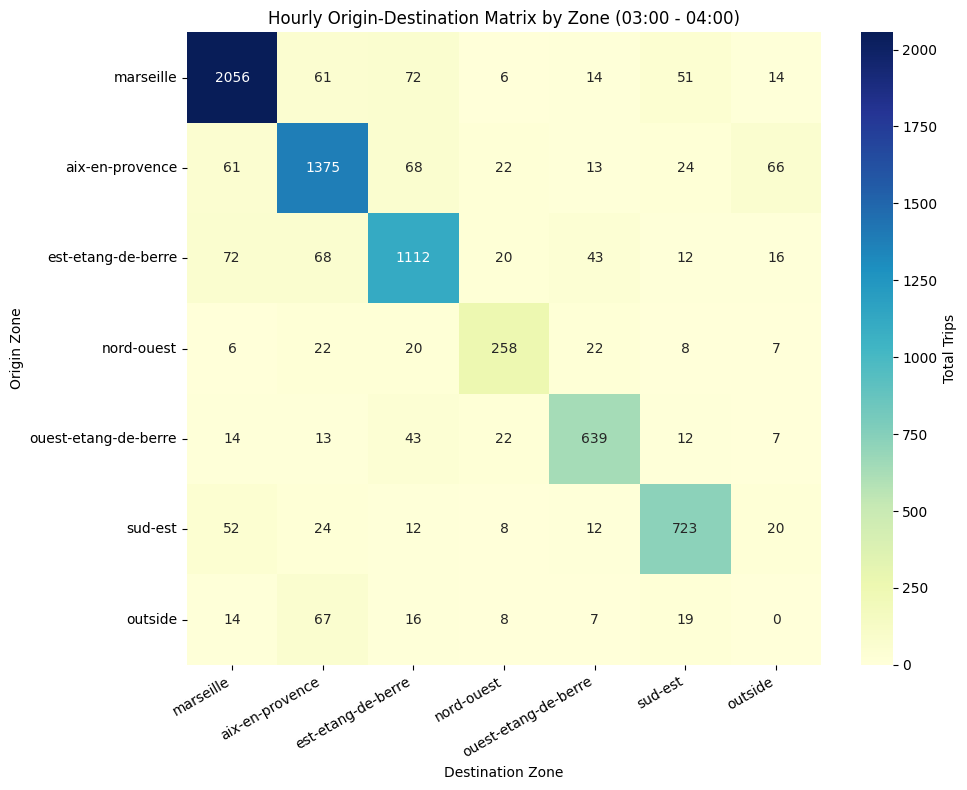

In [12]:
# Re-import necessary libraries after code execution state reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Define file path and TAZ mapping
file_path = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/processed-data/total_scenario/all/OD_00-01.txt")
TAZ_IDS = {
    '1': 'marseille',
    '2': 'aix-en-provence',
    '3': 'est-etang-de-berre',
    '4': 'nord-ouest',
    '5': 'ouest-etang-de-berre',
    '6': 'sud-est',
    '99': 'outside'
}

# Read the file, skipping the first 3 lines
with file_path.open() as f:
    lines = f.readlines()[3:]

# Parse data into DataFrame
data = []
for line in lines:
    parts = line.split()
    if len(parts) == 3:
        origin, destination, trips = parts
        data.append((origin, destination, int(trips)))

df = pd.DataFrame(data, columns=["origin", "destination", "total_trips"])
df["origin"] = df["origin"].map(TAZ_IDS)
df["destination"] = df["destination"].map(TAZ_IDS)

zone_order = [
    'marseille',
    'aix-en-provence',
    'est-etang-de-berre',
    'nord-ouest',
    'ouest-etang-de-berre',
    'sud-est',
    'outside'
]

# Pivot lại ma trận OD
od_matrix = df.pivot(index='origin', columns='destination', values='total_trips').fillna(0)

# Sắp xếp hàng và cột theo thứ tự mong muốn
od_matrix = od_matrix.reindex(index=zone_order, columns=zone_order)

plt.figure(figsize=(10, 8))
sns.heatmap(od_matrix, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Total Trips'})
plt.title("Hourly Origin-Destination Matrix by Zone (03:00 - 04:00)")
plt.xlabel("Destination Zone")
plt.ylabel("Origin Zone")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

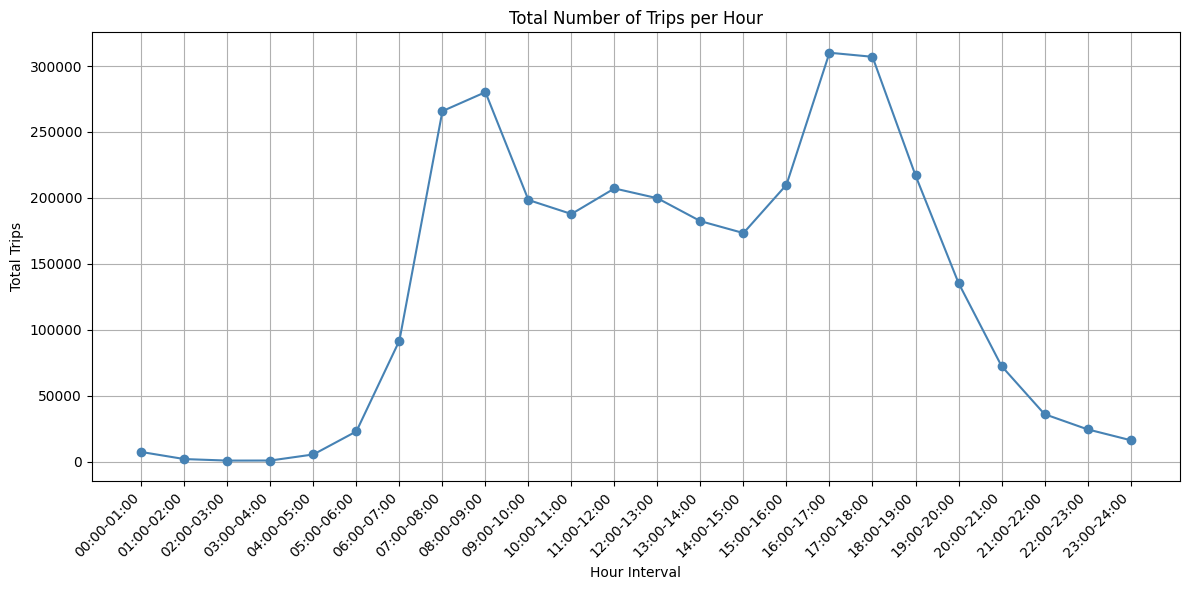

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/processed-data/total_scenario/statistics/hourly_trip_counts.csv")

plt.figure(figsize=(12, 6))
plt.plot(df['hour'], df['total_trips'], marker='o', linestyle='-', color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Hour Interval")
plt.ylabel("Total Trips")
plt.title("Total Number of Trips per Hour")
plt.grid(True)
plt.tight_layout()
plt.show()


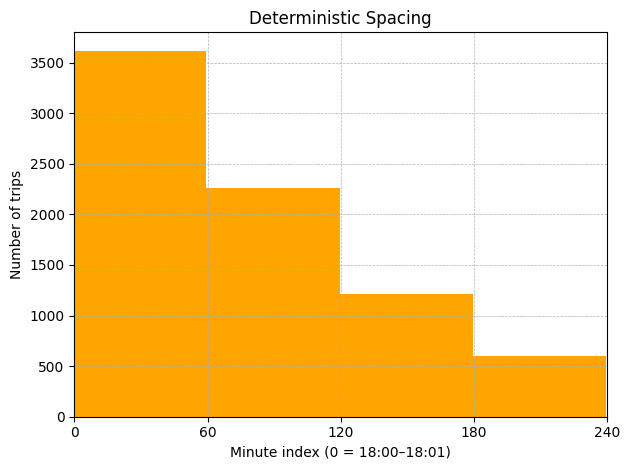

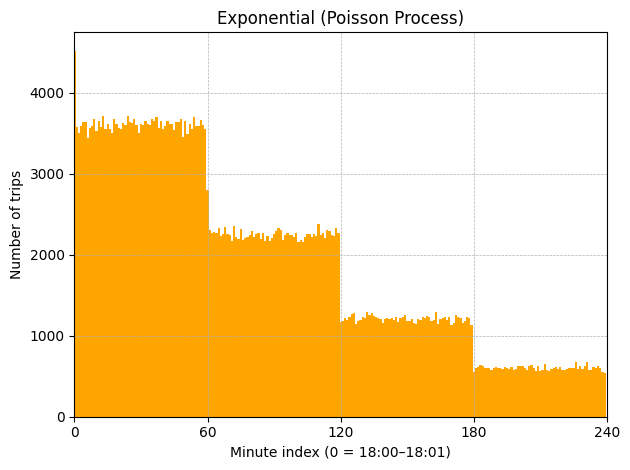

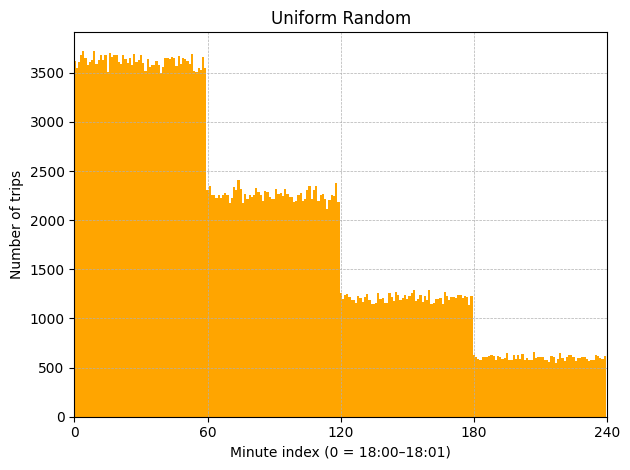

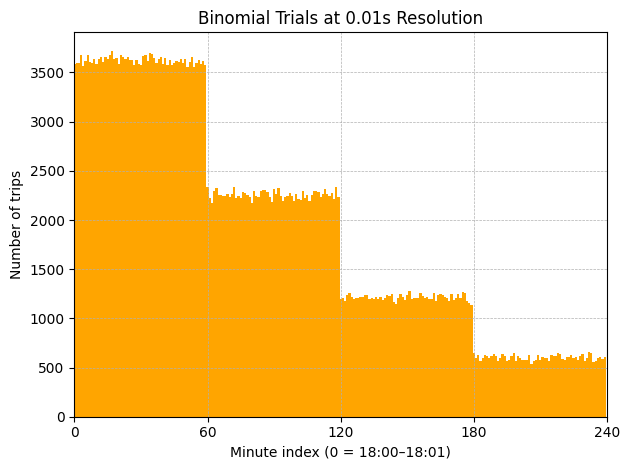

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# --- Input data: trips per hour for 18:00–19:00, 19:00–20:00, 20:00–21:00, 21:00–22:00 ---
counts = [217058, 135485, 72514, 36021]
starts = [0, 3600, 7200, 10800]  # seconds since 18:00
duration = 3600  # seconds per block

# --- 1. Deterministic spacing ---
times_det = np.concatenate([
    start + np.arange(count) * (duration / count)
    for start, count in zip(starts, counts)
])

# --- 2. Exponential interarrival times (Poisson process) ---
times_exp_list = []
for start, count in zip(starts, counts):
    arr = []
    while len(arr) < count:
        inter = np.random.exponential(scale=duration/count, size=int((count - len(arr))*1.2))
        cum = np.cumsum(inter)
        valid = cum[cum <= duration]
        arr.extend(valid.tolist())
    arr = np.array(arr[:count]) + start
    times_exp_list.append(arr)
times_exp = np.concatenate(times_exp_list)

# --- 3. Uniform random departures ---
times_uni = np.concatenate([
    start + np.random.uniform(0, duration, count)
    for start, count in zip(starts, counts)
])

# --- 4. Binomial trials at 0.01s resolution ---
dt = 0.01
times_bin_list = []
for start, count in zip(starts, counts):
    steps = int(duration / dt)
    p = count / steps
    draws = np.random.rand(steps) < p
    arr = np.where(draws)[0] * dt + start
    times_bin_list.append(arr)
times_bin = np.concatenate(times_bin_list)

# --- Helper to plot over 4 hours (240 minutes) ---
def plot_counts(times, title):
    bins = np.arange(0, 4*duration + 60, 60)
    counts_minute, _ = np.histogram(times, bins)
    x = np.arange(len(counts_minute))
    plt.figure()
    plt.bar(x, counts_minute, color='orange', width=1.0)
    plt.xlabel('Minute index (0 = 18:00–18:01)')
    plt.ylabel('Number of trips')
    plt.title(title)
    plt.xlim(0, len(counts_minute))
    plt.xticks(np.arange(0, len(counts_minute)+1, 60))
    plt.grid(axis='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

# --- Generate plots ---
plot_counts(times_det,  'Deterministic Spacing')
plot_counts(times_exp,  'Exponential (Poisson Process)')
plot_counts(times_uni,  'Uniform Random')
plot_counts(times_bin,  'Binomial Trials at 0.01s Resolution')

plt.show()


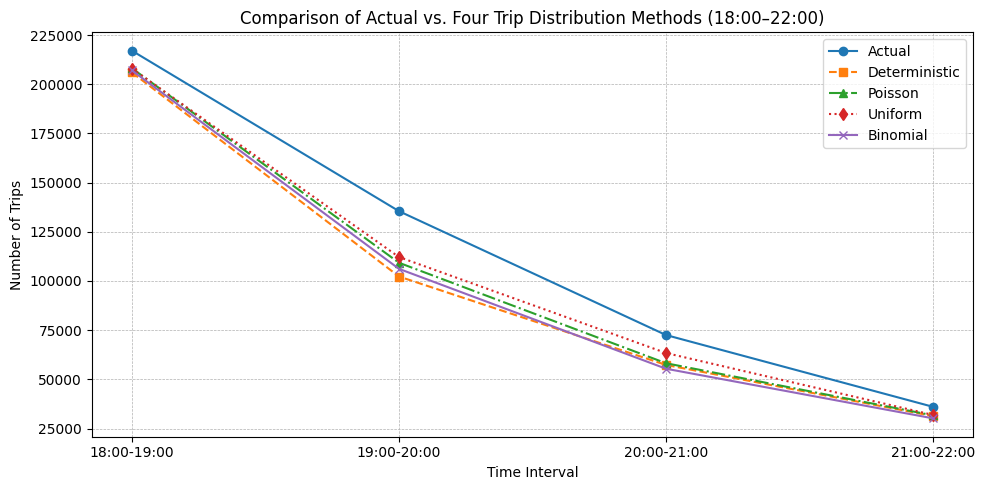

In [22]:
import matplotlib.pyplot as plt

# Time intervals
hours = ['18:00-19:00', '19:00-20:00', '20:00-21:00', '21:00-22:00']

# Data: actual and simulated counts per interval
actual = [217058, 135485, 72514, 36021]
deterministic = [206003, 102271, 57312, 31326]
poisson = [208123, 109254, 58181, 31671]
uniform = [207963, 112168, 63372, 31897]
binomial = [207031, 106157, 55391, 30167]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(hours, actual,      marker='o', linestyle='-',  label='Actual')
plt.plot(hours, deterministic, marker='s', linestyle='--', label='Deterministic')
plt.plot(hours, poisson,      marker='^', linestyle='-.', label='Poisson')
plt.plot(hours, uniform,      marker='d', linestyle=':',  label='Uniform')
plt.plot(hours, binomial,     marker='x', linestyle='-',  label='Binomial')

plt.xlabel('Time Interval')
plt.ylabel('Number of Trips')
plt.title('Comparison of Actual vs. Four Trip Distribution Methods (18:00–22:00)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd

# Input data
hours = ['18:00-19:00', '19:00-20:00', '20:00-21:00', '21:00-22:00']
actual = [217058, 135485, 72514, 36021]
data = {
    'Deterministic': [206003, 102271, 57312, 31326],
    'Poisson':       [208123, 109254, 58181, 31671],
    'Uniform':       [207963, 112168, 63372, 31897],
    'Binomial':      [207031, 106157, 55391, 30167]
}

# Create DataFrame
df = pd.DataFrame(data, index=hours)
actual_series = pd.Series(actual, index=hours)

# Calculate hourly completion percentage for each method
pct_df = df.div(actual_series, axis=0) * 100

# Calculate overall completion percentage for each method
total_pct = df.sum() / actual_series.sum() * 100
pct_df.loc['Total'] = total_pct
pct_df

,Deterministic,Poisson,Uniform,Binomial
18:00-19:00,94.906891,95.883589,95.809876,95.380497
19:00-20:00,75.485109,80.639185,82.789977,78.353323
20:00-21:00,79.035772,80.234162,87.392779,76.386629
21:00-22:00,86.965937,87.923711,88.551123,83.748369
Total,86.083483,88.321065,90.093216,86.481246


In [32]:
import pandas as pd

# Define data
hours = ['18:00-19:00', '19:00-20:00', '20:00-21:00', '21:00-22:00']
data = {
    ('Deterministic', 'Speed (m/s)'): [6.47, 5.81, 6.68, 7.12],
    ('Deterministic', 'Teleport (%)'): [1.23, 3.27, 2.17, 2.33],
    ('Poisson',      'Speed (m/s)'): [6.38, 5.31, 6.37, 7.02],
    ('Poisson',      'Teleport (%)'): [1.17, 3.35, 2.05, 2.03],
    ('Uniform',      'Speed (m/s)'): [6.34, 5.96, 6.41, 7.16],
    ('Uniform',      'Teleport (%)'): [1.12, 3.13, 2.11, 2.06],
    ('Binomial',     'Speed (m/s)'): [6.62, 5.45, 6.23, 7.07],
    ('Binomial',     'Teleport (%)'): [1.03, 3.38, 2.28, 2.10],
}

# Create DataFrame with MultiIndex columns
df = pd.DataFrame(data, index=hours)
df.index.name = 'Interval'

# Calculate mean for each method and metric
mean_row = df.mean().rename('Mean')

# Append mean row by loc assignment
df.loc['Mean'] = mean_row

df

Deterministic                  Poisson                  Uniform  \
              Speed (m/s) Teleport (%) Speed (m/s) Teleport (%) Speed (m/s)   
Interval                                                                      
18:00-19:00          6.47         1.23        6.38         1.17      6.3400   
19:00-20:00          5.81         3.27        5.31         3.35      5.9600   
20:00-21:00          6.68         2.17        6.37         2.05      6.4100   
21:00-22:00          7.12         2.33        7.02         2.03      7.1600   
Mean                 6.52         2.25        6.27         2.15      6.4675   

                            Binomial               
            Teleport (%) Speed (m/s) Teleport (%)  
Interval                                           
18:00-19:00        1.120      6.6200       1.0300  
19:00-20:00        3.130      5.4500       3.3800  
20:00-21:00        2.110      6.2300       2.2800  
21:00-22:00        2.060      7.0700       2.1000  
Mean               2.105      6.3425       2.1975

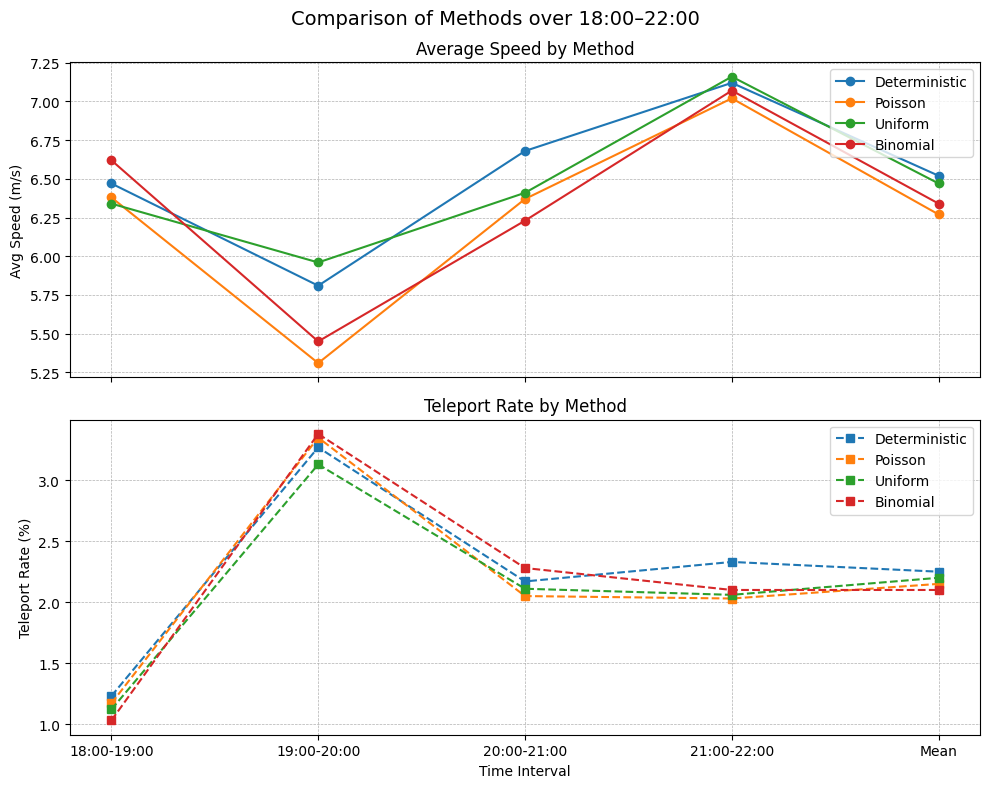

In [33]:
import matplotlib.pyplot as plt

# Data setup
intervals = ['18:00-19:00', '19:00-20:00', '20:00-21:00', '21:00-22:00', 'Mean']
speed = {
    'Deterministic': [6.47, 5.81, 6.68, 7.12, 6.52],
    'Poisson':       [6.38, 5.31, 6.37, 7.02, 6.27],
    'Uniform':       [6.34, 5.96, 6.41, 7.16, 6.47],
    'Binomial':      [6.62, 5.45, 6.23, 7.07, 6.34]
}
teleport = {
    'Deterministic': [1.23, 3.27, 2.17, 2.33, 2.25],
    'Poisson':       [1.17, 3.35, 2.05, 2.03, 2.15],
    'Uniform':       [1.12, 3.13, 2.11, 2.06, 2.20],
    'Binomial':      [1.03, 3.38, 2.28, 2.10, 2.10]
}

# Create a single figure with two stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Plot average speed
for method, vals in speed.items():
    ax1.plot(intervals, vals, marker='o', linestyle='-', label=method)
ax1.set_ylabel('Avg Speed (m/s)')
ax1.set_title('Average Speed by Method')
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.legend(loc='upper right')

# Plot teleport rate
for method, vals in teleport.items():
    ax2.plot(intervals, vals, marker='s', linestyle='--', label=method)
ax2.set_ylabel('Teleport Rate (%)')
ax2.set_title('Teleport Rate by Method')
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.legend(loc='upper right')

# Common X label
ax2.set_xlabel('Time Interval')

plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle('Comparison of Methods over 18:00–22:00', fontsize=14)
plt.show()


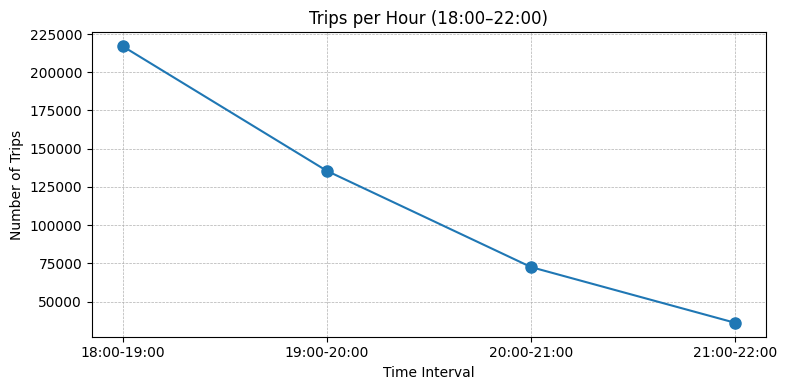

In [19]:
import matplotlib.pyplot as plt

# Data: trips per hour block
hours = ['18:00-19:00', '19:00-20:00', '20:00-21:00', '21:00-22:00']
counts = [217058, 135485, 72514, 36021]

# Plotting points with lines
plt.figure(figsize=(8, 4))
plt.plot(hours, counts, marker='o', linestyle='-', markersize=8)
plt.xlabel('Time Interval')
plt.ylabel('Number of Trips')
plt.title('Trips per Hour (18:00–22:00)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


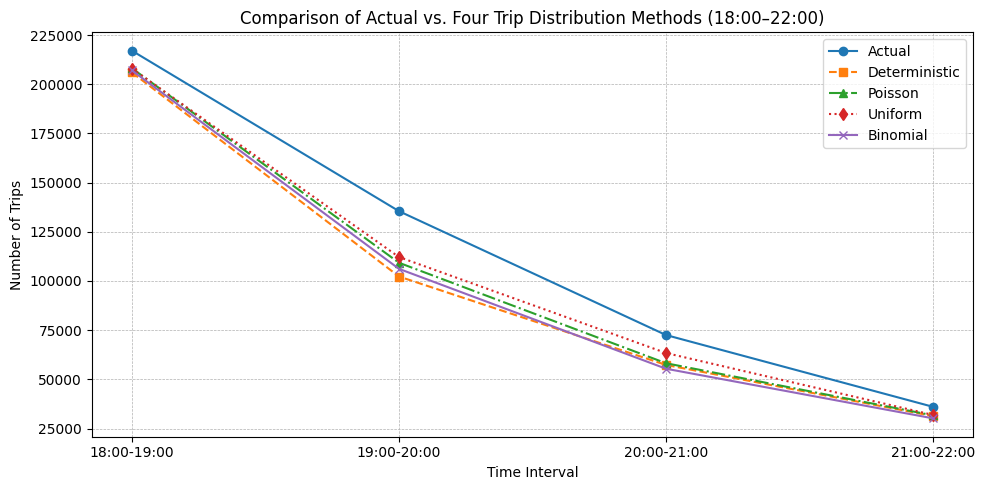

In [35]:
import matplotlib.pyplot as plt

# Time intervals
hours = ['18:00-19:00', '19:00-20:00', '20:00-21:00', '21:00-22:00']

# Data: actual and simulated counts per interval
actual = [217058, 135485, 72514, 36021]
deterministic = [206003, 102271, 57312, 31326]
poisson = [208123, 109254, 58181, 31671]
uniform = [207963, 112168, 63372, 31897]
binomial = [207031, 106157, 55391, 30167]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(hours, actual,      marker='o', linestyle='-',  label='Actual')
plt.plot(hours, deterministic, marker='s', linestyle='--', label='Deterministic')
plt.plot(hours, poisson,      marker='^', linestyle='-.', label='Poisson')
plt.plot(hours, uniform,      marker='d', linestyle=':',  label='Uniform')
plt.plot(hours, binomial,     marker='x', linestyle='-',  label='Binomial')

plt.xlabel('Time Interval')
plt.ylabel('Number of Trips')
plt.title('Comparison of Actual vs. Four Trip Distribution Methods (18:00–22:00)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [278]:
import os
import csv

# Đường dẫn tới thư mục chứa các file
folder_path = "/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/processed-data/total_scenario/old-form-all-result"

# Danh sách lưu kết quả (hour, total_trips)
results = []

# Duyệt qua tất cả các file trong thư mục
for file_name in sorted(os.listdir(folder_path)):
    if file_name.endswith(".txt") and file_name.startswith("od_matrix_"):
        file_path = os.path.join(folder_path, file_name)

        with open(file_path, "r") as f:
            lines = f.readlines()

        # Lấy dòng thứ 2 (index 1) làm giờ
        time_range = lines[1].strip().replace(".", ":")  # "00.00 01.00" -> "00:00 01:00"
        hour = time_range.replace(" ", "-")              # "00:00-01:00"

        # Tính tổng cột thứ 3 từ dòng thứ 4 trở đi (bắt đầu từ index 3)
        total_trips = 0
        for line in lines[3:]:
            parts = line.strip().split()
            if len(parts) == 3:
                try:
                    total_trips += int(parts[2])
                except ValueError:
                    continue  # Bỏ qua nếu không phải số

        # Thêm vào kết quả
        results.append((hour, total_trips))

# Ghi ra file CSV
output_csv = "/home/hoai-linh.dao/zzzz/total_trips_by_hour.csv"
with open(output_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["hour", "total_trips"])  # Header
    writer.writerows(results)

print(f"Đã ghi kết quả vào '{output_csv}' thành công.")


Đã ghi kết quả vào '/home/hoai-linh.dao/zzzz/total_trips_by_hour.csv' thành công.


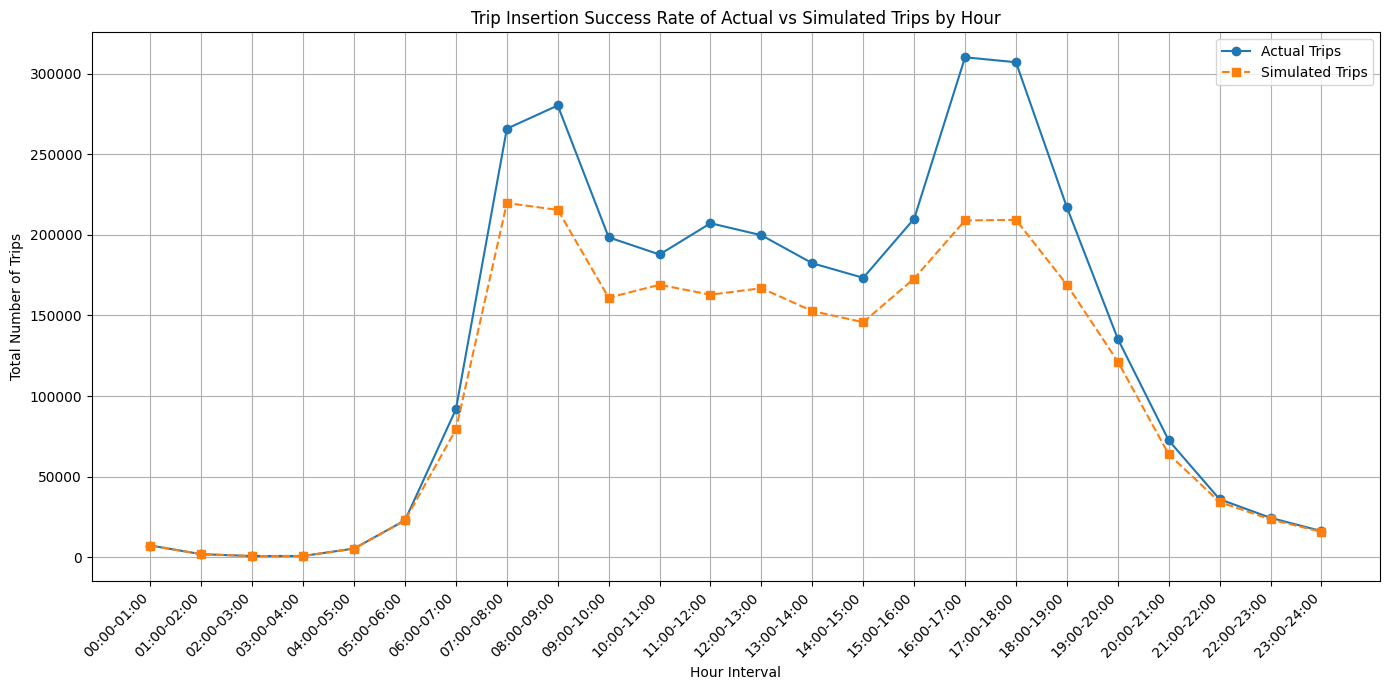


=== Statistical Comparison Metrics ===
Metric          | Value
------------------------------
MAE             | 25992.88
MSE             | 1526863320.62
RMSE            | 39075.10
MAPE            | 12.18%
R² Score        | 0.8651

=== Completion Rate by Hour ===
       hour  actual_trips  simulated_trips completion_rate (%)
00:00-01:00          7321             7321              100.00
01:00-02:00          1961             1960               99.95
02:00-03:00           806              806              100.00
03:00-04:00           856              856              100.00
04:00-05:00          5466             5414               99.05
05:00-06:00         22957            22858               99.57
06:00-07:00         91812            79320               86.39
07:00-08:00        265796           219689               82.65
08:00-09:00        280179           215449               76.90
09:00-10:00        198416           161000               81.14
10:00-11:00        187789           169005 

In [287]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Đọc dữ liệu
df_actual = pd.read_csv("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/processed-data/total_scenario/statistics/hourly_trip_counts.csv")
df_simulated = pd.read_csv("/home/hoai-linh.dao/zzzz/total_trips_by_hour.csv")

# Sắp xếp đúng thứ tự thời gian
df_actual = df_actual.sort_values(by="hour").reset_index(drop=True)
df_simulated = df_simulated.sort_values(by="hour").reset_index(drop=True)

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))
plt.plot(df_actual['hour'], df_actual['total_trips'], marker='o', linestyle='-', label='Actual Trips')
plt.plot(df_simulated['hour'], df_simulated['total_trips'], marker='s', linestyle='--', label='Simulated Trips')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Hour Interval")
plt.ylabel("Total Number of Trips")
plt.title("Trip Insertion Success Rate of Actual vs Simulated Trips by Hour")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
y_true = df_actual['total_trips'].values
y_pred = df_simulated['total_trips'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# In metrics
print("\n=== Statistical Comparison Metrics ===")
print(f"{'Metric':<15} | {'Value'}")
print("-" * 30)
print(f"{'MAE':<15} | {mae:.2f}")
print(f"{'MSE':<15} | {mse:.2f}")
print(f"{'RMSE':<15} | {rmse:.2f}")
print(f"{'MAPE':<15} | {mape:.2f}%")
print(f"{'R² Score':<15} | {r2:.4f}")

# ==== TỈ LỆ HOÀN THÀNH THEO GIỜ ====
completion_df = pd.DataFrame({
    "hour": df_actual['hour'],
    "actual_trips": df_actual['total_trips'],
    "simulated_trips": df_simulated['total_trips']
})
completion_df["completion_rate (%)"] = (completion_df["simulated_trips"] / completion_df["actual_trips"]) * 100

# In bảng
print("\n=== Completion Rate by Hour ===")
print(completion_df.to_string(index=False, formatters={
    'completion_rate (%)': '{:.2f}'.format
}))

# Trung bình
average_completion = completion_df["completion_rate (%)"].mean()
print(f"\nAverage Completion Rate: {average_completion:.2f}%")

total_actual = df_actual["total_trips"].sum()
total_simulated = df_simulated["total_trips"].sum()


# Tính Trip Insertion Success Rate
trip_insertion_success_rate = (total_simulated / total_actual) * 100
print(f"Trip Insertion Success Rate: {trip_insertion_success_rate:.2f}%")


In [280]:
import os
import csv
from collections import defaultdict

# Đường dẫn
folder_path = "/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/processed-data/total_scenario/old-form-all-result"
output_folder = "/home/hoai-linh.dao/zzzz/zone_hourly_sums"
os.makedirs(output_folder, exist_ok=True)

# Dữ liệu: zone_id -> { hour -> total_trips }
zone_hourly_data = defaultdict(lambda: defaultdict(int))

# Duyệt qua các file
for file_name in sorted(os.listdir(folder_path)):
    if file_name.endswith(".txt") and file_name.startswith("od_matrix_"):
        file_path = os.path.join(folder_path, file_name)

        with open(file_path, "r") as f:
            lines = f.readlines()

        # Lấy khung giờ từ dòng thứ 2
        time_range = lines[1].strip().replace(".", ":")
        hour = time_range.replace(" ", "-")

        # Duyệt từng dòng dữ liệu
        for line in lines[3:]:
            parts = line.strip().split()
            if len(parts) == 3:
                try:
                    from_zone = int(parts[0])
                    to_zone = int(parts[1])
                    trips = int(parts[2])
                except ValueError:
                    continue

                # Bỏ qua nếu cả 2 đều là 99
                if from_zone == 99 and to_zone == 99:
                    continue

                # Tính tổng theo giờ cho từng vùng có liên quan (bỏ qua zone 99)
                if from_zone != 99:
                    zone_hourly_data[from_zone][hour] += trips
                if to_zone != 99 and to_zone != from_zone:
                    zone_hourly_data[to_zone][hour] += trips

# Ghi từng vùng ra CSV
for zone_id, hour_dict in zone_hourly_data.items():
    output_path = os.path.join(output_folder, f"{zone_id}.csv")
    with open(output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["hour", "total_trips"])
        for hour in sorted(hour_dict):
            writer.writerow([hour, hour_dict[hour]])

print(f"Đã tạo các file CSV tổng số chuyến theo vùng tại: {output_folder}")


Đã tạo các file CSV tổng số chuyến theo vùng tại: /home/hoai-linh.dao/zzzz/zone_hourly_sums


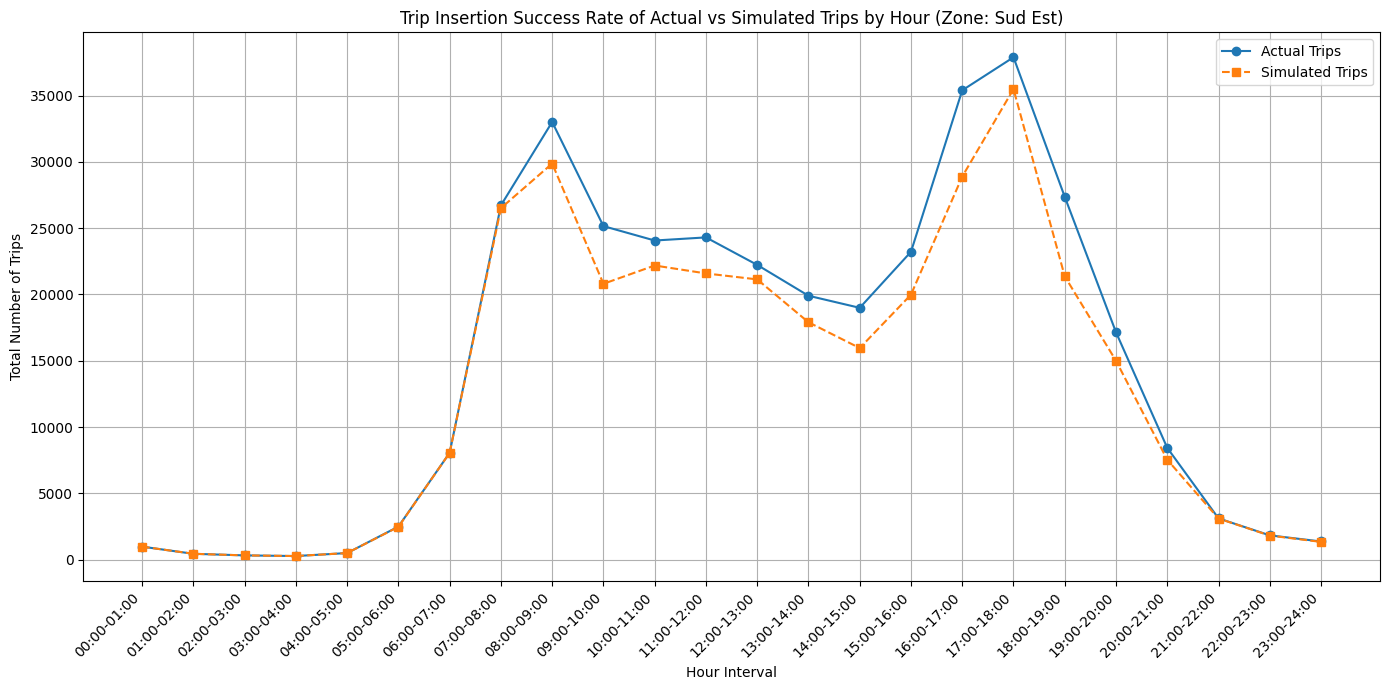


=== Statistical Comparison Metrics ===
Metric          | Value
------------------------------
MAE             | 1653.88
MSE             | 6423791.38
RMSE            | 2534.52
MAPE            | 6.90%
R² Score        | 0.9593

=== Completion Rate by Hour ===
       hour  actual_trips  simulated_trips completion_rate (%)
00:00-01:00           977              977              100.00
01:00-02:00           438              438              100.00
02:00-03:00           317              317              100.00
03:00-04:00           268              268              100.00
04:00-05:00           494              494              100.00
05:00-06:00          2487             2469               99.28
06:00-07:00          8055             8054               99.99
07:00-08:00         26722            26514               99.22
08:00-09:00         33014            29878               90.50
09:00-10:00         25157            20805               82.70
10:00-11:00         24071            22186       

In [295]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Đọc dữ liệu
df_actual = pd.read_csv("/home/hoai-linh.dao/zzzz/zone_hourly_sums_gt/6.csv")
df_simulated = pd.read_csv("/home/hoai-linh.dao/zzzz/zone_hourly_sums/6.csv")

# Sắp xếp đúng thứ tự thời gian
df_actual = df_actual.sort_values(by="hour").reset_index(drop=True)
df_simulated = df_simulated.sort_values(by="hour").reset_index(drop=True)

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))
plt.plot(df_actual['hour'], df_actual['total_trips'], marker='o', linestyle='-', label='Actual Trips')
plt.plot(df_simulated['hour'], df_simulated['total_trips'], marker='s', linestyle='--', label='Simulated Trips')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Hour Interval")
plt.ylabel("Total Number of Trips")
plt.title("Trip Insertion Success Rate of Actual vs Simulated Trips by Hour (Zone: Sud Est)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
y_true = df_actual['total_trips'].values
y_pred = df_simulated['total_trips'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# In metrics
print("\n=== Statistical Comparison Metrics ===")
print(f"{'Metric':<15} | {'Value'}")
print("-" * 30)
print(f"{'MAE':<15} | {mae:.2f}")
print(f"{'MSE':<15} | {mse:.2f}")
print(f"{'RMSE':<15} | {rmse:.2f}")
print(f"{'MAPE':<15} | {mape:.2f}%")
print(f"{'R² Score':<15} | {r2:.4f}")

# ==== TỈ LỆ HOÀN THÀNH THEO GIỜ ====
completion_df = pd.DataFrame({
    "hour": df_actual['hour'],
    "actual_trips": df_actual['total_trips'],
    "simulated_trips": df_simulated['total_trips']
})
completion_df["completion_rate (%)"] = (completion_df["simulated_trips"] / completion_df["actual_trips"]) * 100

# In bảng
print("\n=== Completion Rate by Hour ===")
print(completion_df.to_string(index=False, formatters={
    'completion_rate (%)': '{:.2f}'.format
}))

# Trung bình
average_completion = completion_df["completion_rate (%)"].mean()
print(f"\nAverage Completion Rate: {average_completion:.2f}%")

total_actual = df_actual["total_trips"].sum()
total_simulated = df_simulated["total_trips"].sum()

# Tính Trip Insertion Success Rate
trip_insertion_success_rate = (total_simulated / total_actual) * 100
print(f"Trip Insertion Success Rate: {trip_insertion_success_rate:.2f}%")


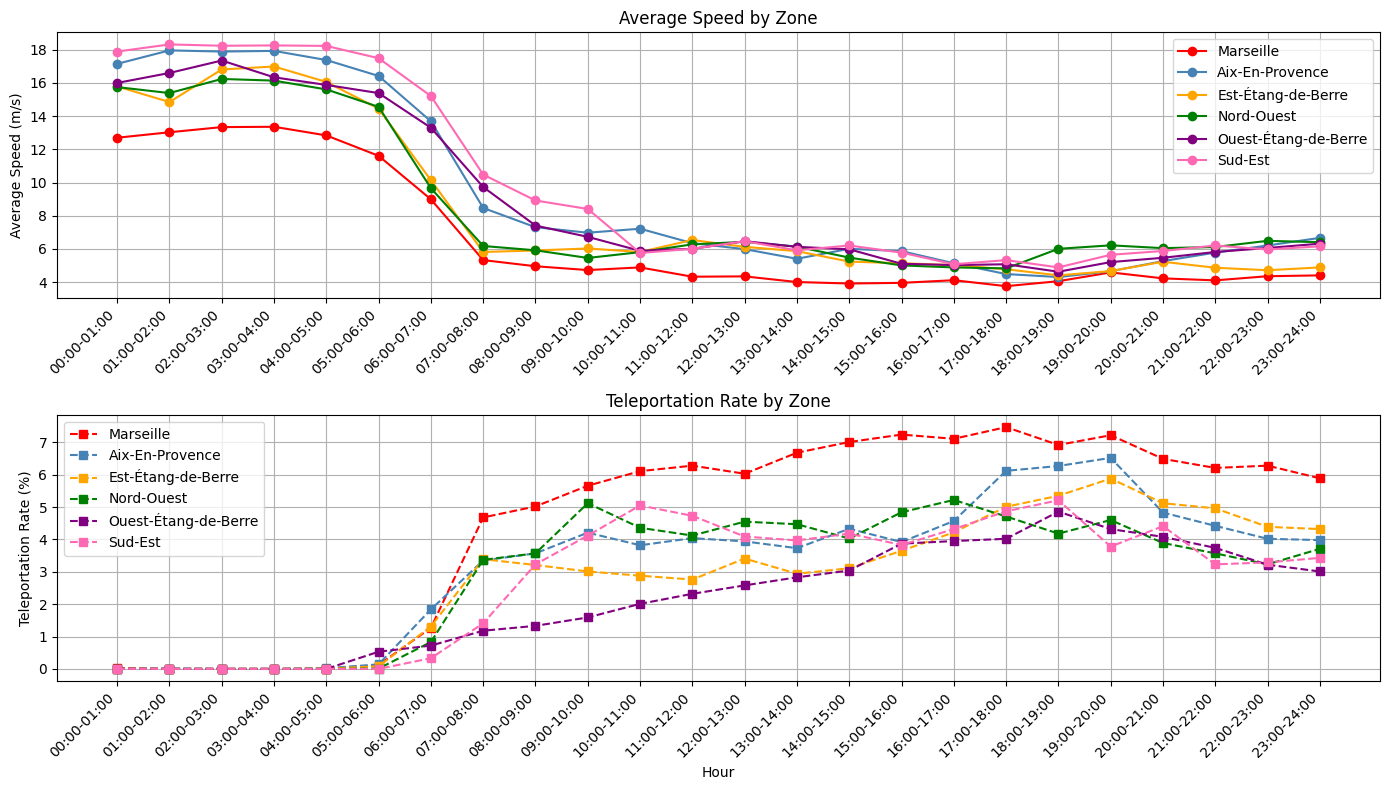


===== Zone 1 - Marseille =====
       hour  total_trips  avg_speed  teleportation_rate
00:00-01:00         2493      12.70                0.02
01:00-02:00          796      13.03                0.00
02:00-03:00          152      13.34                0.00
03:00-04:00          109      13.36                0.00
04:00-05:00         1429      12.84                0.00
05:00-06:00         7100      11.61                0.12
06:00-07:00        23548       8.99                1.27
07:00-08:00        74962       5.33                4.68
08:00-09:00        74113       4.96                5.02
09:00-10:00        64192       4.73                5.66
10:00-11:00        62801       4.89                6.11
11:00-12:00        61889       4.33                6.28
12:00-13:00        63085       4.35                6.03
13:00-14:00        61275       4.01                6.68
14:00-15:00        59196       3.92                7.01
15:00-16:00        61809       3.96                7.24
16:00-17:00     

In [283]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Thư mục chứa dữ liệu
zone_folder = "/home/hoai-linh.dao/zzzz/zone_hourly_sums-vt"

# Zone ID, tên vùng và màu tương ứng
zones = {
    1: {"name": "Marseille", "color": "red"},
    2: {"name": "Aix-En-Provence", "color": "steelblue"},
    3: {"name": "Est-Étang-de-Berre", "color": "orange"},
    4: {"name": "Nord-Ouest", "color": "green"},
    5: {"name": "Ouest-Étang-de-Berre", "color": "purple"},
    6: {"name": "Sud-Est", "color": "hotpink"}
}

# Khởi tạo dict lưu dữ liệu
avg_speeds = {}
teleport_rates = {}
hours = None

# Đọc dữ liệu từ các file
for zone_id, info in zones.items():
    file_path = os.path.join(zone_folder, f"{zone_id}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        avg_speeds[zone_id] = df["avg_speed"].values
        teleport_rates[zone_id] = df["teleportation_rate"].values
        if hours is None:
            hours = df["hour"].values
    else:
        print(f"⚠️ File không tồn tại: {file_path}")

if not avg_speeds:
    print("❌ Không có dữ liệu để vẽ.")
    exit()

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))

# Biểu đồ tốc độ trung bình
plt.subplot(2, 1, 1)
for zone_id, values in avg_speeds.items():
    name = zones[zone_id]["name"]
    color = zones[zone_id]["color"]
    plt.plot(hours, values, marker='o', label=name, color=color)
plt.ylabel("Average Speed (m/s)")
plt.title("Average Speed by Zone")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend()

# Biểu đồ teleport rate
plt.subplot(2, 1, 2)
for zone_id, values in teleport_rates.items():
    name = zones[zone_id]["name"]
    color = zones[zone_id]["color"]
    plt.plot(hours, values, marker='s', linestyle='--', label=name, color=color)
plt.xlabel("Hour")
plt.ylabel("Teleportation Rate (%)")
plt.title("Teleportation Rate by Zone")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

for zone_id, info in zones.items():
    file_path = os.path.join(zone_folder, f"{zone_id}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        avg_speeds[zone_id] = df["avg_speed"].values
        teleport_rates[zone_id] = df["teleportation_rate"].values
        if hours is None:
            hours = df["hour"].values
        
        # In bảng dữ liệu ra console
        print(f"\n===== Zone {zone_id} - {info['name']} =====")
        print(df.to_string(index=False))  # In toàn bộ nội dung không có index
    else:
        print(f"⚠️ File không tồn tại: {file_path}")



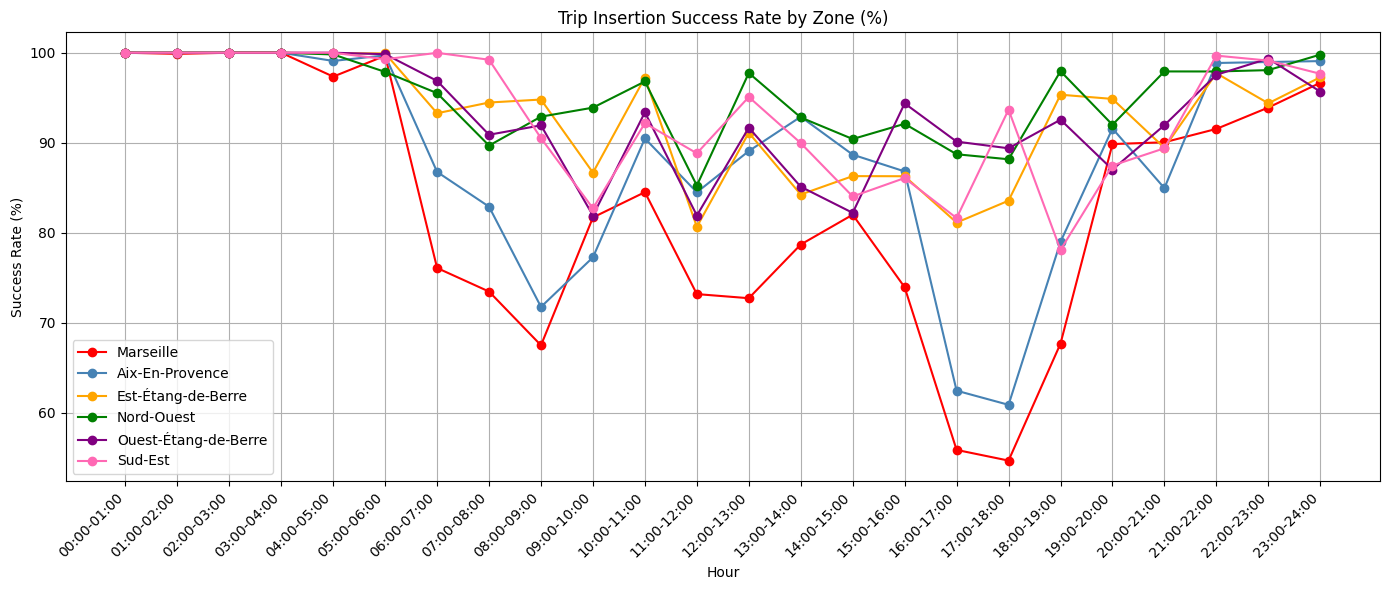


=== Trip Insertion Success Rate by Hour ===
       hour  Marseille  Aix-En-Provence  Est-Étang-de-Berre  Nord-Ouest  Ouest-Étang-de-Berre  Sud-Est
00:00-01:00     100.00           100.00              100.00      100.00                100.00   100.00
01:00-02:00      99.87           100.00              100.00      100.00                100.00   100.00
02:00-03:00     100.00           100.00              100.00      100.00                100.00   100.00
03:00-04:00     100.00           100.00              100.00      100.00                100.00   100.00
04:00-05:00      97.34            99.09               99.92       99.81                100.00   100.00
05:00-06:00      99.66            99.70               99.93       97.87                 99.84    99.28
06:00-07:00      76.07            86.75               93.27       95.51                 96.87    99.99
07:00-08:00      73.45            82.88               94.46       89.68                 90.88    99.22
08:00-09:00      67.47      

In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Thư mục chứa dữ liệu
sim_folder = "/home/hoai-linh.dao/zzzz/zone_hourly_sums-vt"
gt_folder = "/home/hoai-linh.dao/zzzz/zone_hourly_sums_gt"

zones = {
    1: {"name": "Marseille", "color": "red"},
    2: {"name": "Aix-En-Provence", "color": "steelblue"},
    3: {"name": "Est-Étang-de-Berre", "color": "orange"},
    4: {"name": "Nord-Ouest", "color": "green"},
    5: {"name": "Ouest-Étang-de-Berre", "color": "purple"},
    6: {"name": "Sud-Est", "color": "hotpink"}
}

insertion_success = {}
hours = None

for zone_id, info in zones.items():
    sim_file = os.path.join(sim_folder, f"{zone_id}.csv")
    gt_file = os.path.join(gt_folder, f"{zone_id}.csv")

    if not os.path.exists(sim_file) or not os.path.exists(gt_file):
        print(f"⚠️ Missing file for zone {zone_id}")
        continue

    df_sim = pd.read_csv(sim_file)
    df_gt = pd.read_csv(gt_file)

    if hours is None:
        hours = df_sim["hour"].values

    sim_trips = df_sim["total_trips"].replace(0, pd.NA)
    gt_trips = df_gt["total_trips"].replace(0, pd.NA)

    success_rate = (sim_trips / gt_trips) * 100
    insertion_success[zone_id] = success_rate

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
for zone_id, rates in insertion_success.items():
    plt.plot(hours, rates, marker='o', label=zones[zone_id]["name"], color=zones[zone_id]["color"])
plt.title("Trip Insertion Success Rate by Zone (%)")
plt.xlabel("Hour")
plt.ylabel("Success Rate (%)")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# In bảng ra console
print("\n=== Trip Insertion Success Rate by Hour ===")
result_df = pd.DataFrame({"hour": hours})
for zone_id, rates in insertion_success.items():
    result_df[zones[zone_id]["name"]] = rates.values

# Làm tròn và in ra bảng
print(result_df.round(2).to_string(index=False))


In [296]:
import pandas as pd

# Đọc file CSV gốc
df = pd.read_csv('/home/hoai-linh.dao/zzzz/low-battery.csv')

# Lọc chỉ giữ các cột x, y, edge_id
df_new = df[['x', 'y', 'edge_id']]

# Ghi ra file CSV mới
df_new.to_csv('/home/hoai-linh.dao/zzzz/low-battery-trace.csv', index=False)


In [320]:
import pandas as pd
import xml.etree.ElementTree as ET

df = pd.read_csv('/home/hoai-linh.dao/zzzz/low-battery-trace.csv')
additional = ET.Element('additional')

for idx, row in df.iterrows():
    safe_id = str(row.edge_id).replace('#','_').replace('-','m')
    uid = f'cdp_{safe_id}_{idx}'
    ET.SubElement(additional, 'poi', {
        'id': uid,
        'x': f"{row.x:.2f}",
        'y': f"{row.y:.2f}",
        'poiType': "charging-demand point",
        'color': "green",        # hoặc "#00FF00"
        'shape': "circle",      
        'width': "200",          # tăng lên nếu cần to hơn
        'height': "12",
        'layer': "2000"
    })

tree = ET.ElementTree(additional)
tree.write('/home/hoai-linh.dao/zzzz/low-bat.additional.xml',
           encoding='utf-8', xml_declaration=True)


In [322]:
#!/usr/bin/env python3
# hotspot_detection.py

import pandas as pd
from sklearn.cluster import DBSCAN
import xml.etree.ElementTree as ET

def main():
    # 1) đọc dữ liệu
    df = pd.read_csv("/home/hoai-linh.dao/zzzz/low-battery-trace.csv")

    # 1.1) loại bỏ các dòng thiếu tọa độ
    before = len(df)
    df = df.dropna(subset=['x','y'])
    after = len(df)
    if before != after:
        print(f"Đã bỏ {before-after} dòng thiếu x/y")

    # 2) trích tọa độ vào numpy array
    coords = df[['x', 'y']].values

    # 3) chạy DBSCAN (eps=200m, min_samples=5)
    db = DBSCAN(eps=200, min_samples=5).fit(coords)
    df['cluster'] = db.labels_

    # 4) gom nhóm, tính centroid và kích thước hiển thị
    clusters = (
        df[df.cluster >= 0]
          .groupby('cluster')
          .agg(count=('cluster','size'),
               x_mean=('x','mean'),
               y_mean=('y','mean'))
          .reset_index()
    )

    # 5) tạo file XML cho SUMO
    root = ET.Element('additional')
    for _, row in clusters.iterrows():
        size = 150 + 10 * row['count']  # base=8, slope=1.5
        ET.SubElement(root, 'poi', {
            'id':       f"hot_{int(row.cluster)}",
            'x':        f"{row.x_mean:.2f}",
            'y':        f"{row.y_mean:.2f}",
            'poiType':  "charging-hotspot",
            'color':    "#FF6600",      # cam nóng
            'shape':    "circle",
            'width':    f"{size:.1f}",
            'height':   f"{size:.1f}",
            'layer':    "2000"
        })

    tree = ET.ElementTree(root)
    tree.write('/home/hoai-linh.dao/zzzz/low-bat.hotspots.xml',
               encoding='utf-8', xml_declaration=True)
    print(f"Xuất xong {len(clusters)} hotspot vào low-bat.hotspots.xml")

if __name__ == '__main__':
    main()


Đã bỏ 1 dòng thiếu x/y
Xuất xong 152 hotspot vào low-bat.hotspots.xml


In [323]:
import xml.etree.ElementTree as ET

# Đường dẫn tới file XML gốc và file đích
INPUT_FILE  = '/home/hoai-linh.dao/Works/EVCS/AMP-Metropole/Draft-19-03-25/charging_station.xml'
OUTPUT_FILE = '/home/hoai-linh.dao/Works/EVCS/AMP-Metropole/Draft-19-03-25/charging_station.xml'

# Kích thước mới (đơn vị: mét/pixel trong NetEdit)
NEW_SIZE = 200  # tăng lên 50, 100… tuỳ bạn

# Đọc và parse XML
tree = ET.parse(INPUT_FILE)
root = tree.getroot()

# Lặp qua tất cả các <poi> và gán width/height (và layer nếu muốn)
for poi in root.findall('poi'):
    poi.set('width',  str(NEW_SIZE))
    poi.set('height', str(NEW_SIZE))
    # nếu muốn luôn nằm trên cùng:
    poi.set('layer', '2000')
    # giữ nguyên color="blue" hoặc thay đổi tại đây:
    # poi.set('color', '#006400')  # ví dụ xanh lá đậm

# Ghi ra file mới
tree.write(OUTPUT_FILE, encoding='utf-8', xml_declaration=True)
print(f"Đã ghi file với kích thước {NEW_SIZE}×{NEW_SIZE}: {OUTPUT_FILE}")


Đã ghi file với kích thước 200×200: /home/hoai-linh.dao/Works/EVCS/AMP-Metropole/Draft-19-03-25/charging_station.xml
